In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import random
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")


plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# preprocessing
def prepro(file_path, split_rate):
    # read csv
    df = pd.read_csv(file_path)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # split the label
    X = df.iloc[:, 3:-1].values  
    y = df.iloc[:, -1].values   

    x_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-split_rate, stratify=y, random_state=42)

    x_valid, x_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, 255))

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_valid = scaler.transform(x_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test


def data_pre(file_path, split_rate, sequence_length):
    x_train, y_train, x_valid, y_valid, x_test, y_test = prepro(file_path, split_rate)

    y_train = [int(i) for i in y_train]
    y_valid = [int(i) for i in y_valid]
    y_test = [int(i) for i in y_test]

    # shuffle
    index = [i for i in range(len(x_train))]
    random.seed(1)
    random.shuffle(index)
    x_train = np.array(x_train)[index]
    y_train = np.array(y_train)[index]

    index1 = [i for i in range(len(x_valid))]
    random.shuffle(index1)
    x_valid = np.array(x_valid)[index1]
    y_valid = np.array(y_valid)[index1]

    index2 = [i for i in range(len(x_test))]
    random.shuffle(index2)
    x_test = np.array(x_test)[index2]
    y_test = np.array(y_test)[index2]

    # split the data into window 
    def create_sequences(data, labels, sequence_length):
        sequences = []
        sequence_labels = []
        for i in range(len(data) - sequence_length + 1):
            sequences.append(data[i:i + sequence_length])
            sequence_labels.append(labels[i + sequence_length - 1])  
        return np.array(sequences), np.array(sequence_labels)

    x_train, y_train = create_sequences(x_train, y_train, sequence_length)
    x_valid, y_valid = create_sequences(x_valid, y_valid, sequence_length)
    x_test, y_test = create_sequences(x_test, y_test, sequence_length)

    # 转换为 PyTorch 张量
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_valid = torch.tensor(x_valid, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_valid = torch.tensor(y_valid, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    return x_train, y_train, x_valid, y_valid, x_test, y_test


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  
        return out




def model_train(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size, epochs):
    train_dataset = TensorDataset(x_train, y_train)
    valid_dataset = TensorDataset(x_valid, y_valid)
    test_dataset = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = x_train.shape[2]
    sequence_length = x_train.shape[1]
    hidden_size = 64
    num_layers = 2
    num_classes = len(np.unique(y_train))

    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    patience =20
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct.double() / len(train_loader.dataset)

        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                valid_correct += torch.sum(preds == labels.data)

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_correct.double() / len(valid_loader.dataset)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # early stop
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            counter = 0
            # save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stop！")
                break

        scheduler.step(valid_loss)

        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

    # Eval testset
    model.eval()
    test_correct = 0
    y_pred_int = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels.data)
            y_pred_int.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_accuracy = test_correct.double() / len(test_loader.dataset)
    print("=========Model Train End==========")
    print("Test set accuracy： ", f'Accuracy: {test_accuracy:.2%}')

    print("Confusion matrix output：")
    print(classification_report(y_true, y_pred_int, digits=4))

    # calculate cm
    cm = confusion_matrix(y_true, y_pred_int)

    # plot cm
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {
        'loss': train_losses,
        'val_loss': valid_losses,
        'accuracy': train_accuracies,
        'val_accuracy': valid_accuracies
    }, model

# plot acc and loss
def acc_loss_line(history):
    print("Plot the accuracy and loss curve")
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # plot accuracy
    plt.plot(epochs, acc, 'r', linestyle='-.')
    plt.plot(epochs, val_acc, 'b', linestyle='dashdot')
    plt.title('Accuracy of train set and validation set')
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train set accuracy", "Validation set accuracy"])

    plt.figure()

    # plot loss
    plt.plot(epochs, loss, 'r', linestyle='-.')
    plt.plot(epochs, val_loss, 'b', linestyle='dashdot')
    plt.title('Loss of train set and validation set')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend(["Train set loss", "Validation set loss"])

    plt.show()



Epoch 1/100, Train Loss: 0.5537, Train Accuracy: 0.8400, Valid Loss: 0.2258, Valid Accuracy: 0.9436
Epoch 2/100, Train Loss: 0.2171, Train Accuracy: 0.9418, Valid Loss: 0.2039, Valid Accuracy: 0.9425
Epoch 3/100, Train Loss: 0.2044, Train Accuracy: 0.9428, Valid Loss: 0.1856, Valid Accuracy: 0.9458
Epoch 4/100, Train Loss: 0.1980, Train Accuracy: 0.9453, Valid Loss: 0.1880, Valid Accuracy: 0.9549
Epoch 5/100, Train Loss: 0.1969, Train Accuracy: 0.9491, Valid Loss: 0.1871, Valid Accuracy: 0.9531
Epoch 6/100, Train Loss: 0.1966, Train Accuracy: 0.9500, Valid Loss: 0.1945, Valid Accuracy: 0.9563
Epoch 7/100, Train Loss: 0.1938, Train Accuracy: 0.9511, Valid Loss: 0.1928, Valid Accuracy: 0.9559
Epoch 8/100, Train Loss: 0.1950, Train Accuracy: 0.9517, Valid Loss: 0.1866, Valid Accuracy: 0.9553
Epoch 9/100, Train Loss: 0.1942, Train Accuracy: 0.9518, Valid Loss: 0.1810, Valid Accuracy: 0.9562
Epoch 10/100, Train Loss: 0.1933, Train Accuracy: 0.9520, Valid Loss: 0.1822, Valid Accuracy: 0.9541

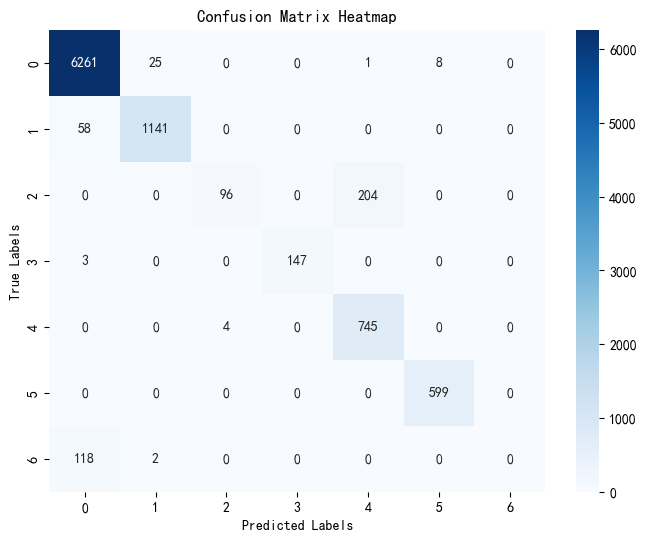

Plot the accuracy and loss curve


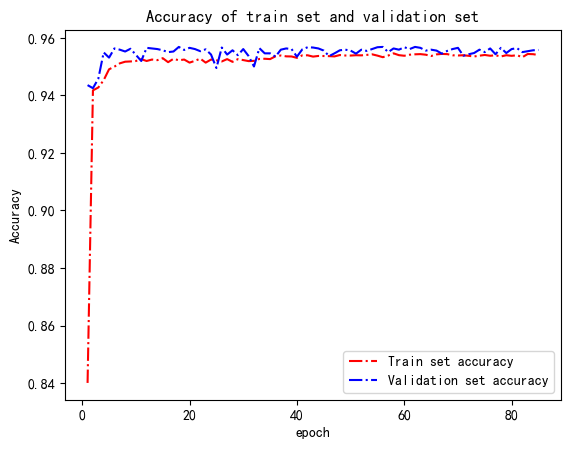

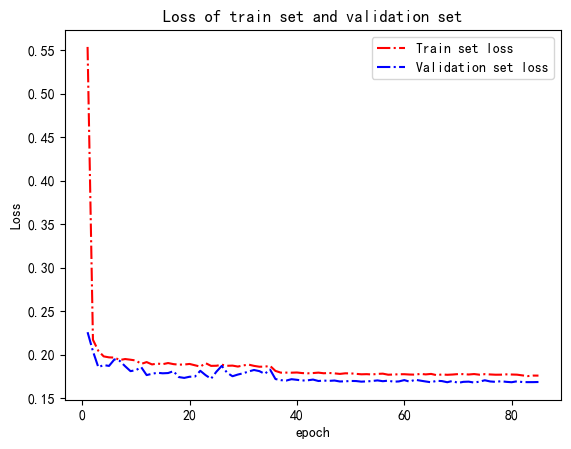

In [9]:
if __name__ == '__main__':
    file_path = '../data/cic.csv'
    sequence_length = 10  
    split_rate = 0.7 
    batch_size = 128 
    epochs = 100  

    x_train, y_train, x_valid, y_valid, x_test, y_test = data_pre(file_path, split_rate, sequence_length)

    history, model = model_train(x_train, y_train, x_valid, y_valid, x_test, y_test, batch_size, epochs)

    acc_loss_line(history)
